In [43]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


## Import statements

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import cv2
import pandas as pd
import ntpath
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## Load the data

In [45]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df = pd.read_csv("/content/track/driving_log.csv",names = columns)
data = pd.read_csv("/content/track/driving_log.csv",names = columns)

def extract_filename(path):
  return ntpath.basename(path)
data['center'] = data['center'].apply(extract_filename)
data['left'] = data['left'].apply(extract_filename)
data['right'] = data['right'].apply(extract_filename)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [46]:
df.duplicated().sum()

np.int64(0)

## Visualization

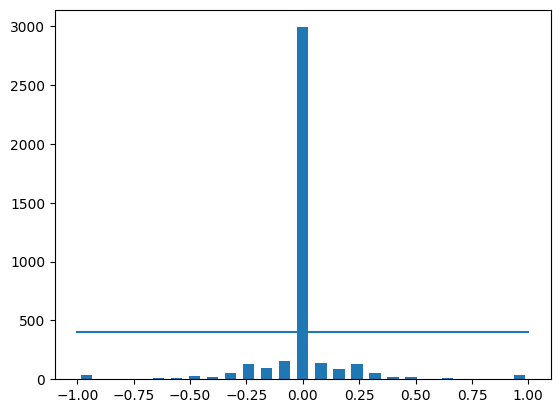

In [47]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))

# The number of zeros are very high so we can remove the zeroes to avoid biases
# in our training module

In [48]:
bins

array([-1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44, -0.36,
       -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,
        0.44,  0.52,  0.6 ,  0.68,  0.76,  0.84,  0.92,  1.  ])

In [ ]:
num_bins = 25
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

In [ ]:
data.shape

In [ ]:
df.shape

In [ ]:
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [ ]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [ ]:
image_paths[:4]

In [ ]:
len(image_paths),len(steerings)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

In [ ]:
# Visualizing the training target(steerings angle)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set');

In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)

plt.imshow(original_image);

In [ ]:
original_image.shape

In [ ]:
def preprocess_image(path):
  # Read the image
  image = tf.io.read_file(path)
  # Turning the image into tensors with 3 color channel
  image = tf.image.decode_jpeg(image,channels = 3)
  # Convert the color channel in the range 0 to 1
  image = tf.image.convert_image_dtype(image,tf.float32)
  return image

In [152]:
## Create a simple function that returns a tuple '(image,label)'

def get_image_label(image_path,label):
  image = preprocess_image(image_path)
  return image,label

In [153]:
BATCH_SIZE = 32

def create_train_val_batches(X, y, batch_size=BATCH_SIZE, val_split=0.2):
    """
    Splits the data into training and validation sets (default 80-20),
    then converts them into TensorFlow data batches.

    Parameters:
        X (list or array): List of image file paths
        y (list or array): List of corresponding labels
        batch_size (int): Size of the batch
        val_split (float): Fraction of validation data

    Returns:
        train_data (tf.data.Dataset): Training data batches
        val_data (tf.data.Dataset): Validation data batches
    """

    # Split into training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, random_state=42)

    print(f"Total samples: {len(X)}")
    print(f"Training samples: {len(X_train)} | Validation samples: {len(X_val)}")

    # Create training dataset
    train_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_train), tf.constant(y_train)))
    train_data = train_data.shuffle(buffer_size=len(X_train))
    train_data = train_data.map(get_image_label)
    train_data = train_data.batch(batch_size)

    # Create validation dataset
    val_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_val), tf.constant(y_val)))
    val_data = val_data.map(get_image_label)
    val_data = val_data.batch(batch_size)

    return train_data, val_data

In [154]:
train_data, val_data = create_train_val_batches(image_paths, steerings)

Total samples: 4389
Training samples: 3511 | Validation samples: 878


In [49]:
BATCH_SIZE = 32
rotation_layer = tf.keras.layers.RandomRotation(0.1)
translation_layer = tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
def random_rotate(image):
    return rotation_layer(image)

def random_translate(image):
    return translation_layer(image)

def img_random_brightness(image):
    return tf.image.random_brightness(image, max_delta=0.2)

def img_random_flip(image, steering_angle):
    should_flip = tf.random.uniform([]) < 0.5
    image = tf.cond(should_flip, lambda: tf.image.flip_left_right(image), lambda: image)
    steering_angle = tf.cond(should_flip, lambda: -steering_angle, lambda: steering_angle)
    return image, steering_angle

def augment_image(image, steering_angle):
    image = tf.cast(image, tf.float32)
    if random.randint(0,10) < 5:
      image = random_rotate(image)
    if random.randint(0,10) < 5:
      image = random_translate(image)
    if random.randint(0,10) < 5:
      image = img_random_brightness(image)
    image, steering_angle = img_random_flip(image, steering_angle)
    image = tf.clip_by_value(image / 255.0, 0.0, 1.0)
    return image, steering_angle

In [50]:
def img_preprocess(img):
    # Slice the image (equivalent to img[60:135,:,:] in NumPy)
    img = img[60:135, :, :]

    # Ensure the image is in float32 and normalize it to the range [0, 1]
    img = tf.cast(img, tf.float32) / 255.0  # Convert to float and normalize

    # Convert the image from RGB to YUV
    img = tf.image.rgb_to_yuv(img)

    # Apply Gaussian blur
    kernel = tf.constant([
        [1.0, 2.0, 1.0],
        [2.0, 4.0, 2.0],
        [1.0, 2.0, 1.0]
    ], dtype=tf.float32) / 16.0  # Normalize the kernel

    # Expand the kernel to match the depth (3 channels)
    kernel = tf.repeat(kernel[:, :, tf.newaxis], 3, axis=-1)  # Repeat the kernel for 3 channels

    # Perform the convolution (use the correct depth in the kernel)
    img = tf.nn.conv2d(tf.expand_dims(img, axis=0), kernel[:, :, :, tf.newaxis], strides=[1, 1, 1, 1], padding="SAME")

    # Remove the batch dimension
    img = tf.squeeze(img, axis=0)  # Remove the batch dimension

    # Resize the image to 200x66
    img = tf.image.resize(img, (66, 200))

    # Normalize the image by dividing by 255 (optional if you want to ensure it's in [0, 1] range)
    img = img / 255.0

    return img

In [51]:
def get_image_label_train(image_path, steering_angle):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = img_preprocess(image)

    # Apply augmentations
    image, steering_angle = augment_image(image, steering_angle)

    return image, steering_angle

In [52]:
def get_image_label_test(image_path, steering_angle):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = img_preprocess(image)

    return image, steering_angle

In [53]:
def create_train_val_batches(X, y, batch_size=BATCH_SIZE, val_split=0.2):
    """
    Splits the data into training and validation sets (default 80-20),
    then converts them into TensorFlow data batches.

    Parameters:
        X (list or array): List of image file paths
        y (list or array): List of corresponding labels
        batch_size (int): Size of the batch
        val_split (float): Fraction of validation data

    Returns:
        train_data (tf.data.Dataset): Training data batches
        val_data (tf.data.Dataset): Validation data batches
    """
    # Split into training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, random_state=42)

    print(f"Total samples: {len(X)}")
    print(f"Training samples: {len(X_train)} | Validation samples: {len(X_val)}")

    # Create training dataset
    train_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_train), tf.constant(y_train)))
    train_data = train_data.shuffle(buffer_size=len(X_train))  # Shuffle training data
    train_data = train_data.map(get_image_label_train)  # Apply preprocessing
    train_data = train_data.batch(batch_size)  # Batch the data

    # Create validation dataset (no augmentation here)
    val_data = tf.data.Dataset.from_tensor_slices((tf.constant(X_val), tf.constant(y_val)))
    val_data = val_data.map(get_image_label_test)  # Apply preprocessing
    val_data = val_data.batch(batch_size)  # Batch the data
    return train_data, val_data

# Create the training and validation data batches
train_data, val_data = create_train_val_batches(image_paths, steerings)

Total samples: 4389
Training samples: 3511 | Validation samples: 878


(66, 200, 1)


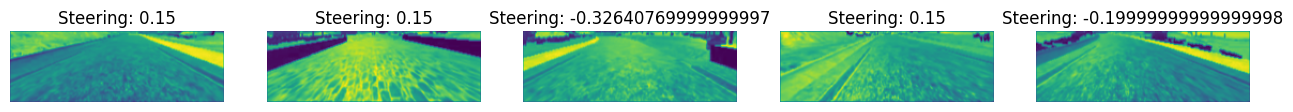

In [54]:
def visualize_random_images(train_data, num_images=5):
    # Get a batch of data from train_data
    for image_batch, label_batch in train_data.take(1):  # Take 1 batch from train_data
        # We want to display only 'num_images' random images
        random_indices = tf.random.uniform([num_images], minval=0, maxval=image_batch.shape[0], dtype=tf.int32)
        random_images = tf.gather(image_batch, random_indices)
        print(random_images[1].shape)

        # Plot the images
        plt.figure(figsize=(16, 16))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(random_images[i].numpy())  # Convert tensor to NumPy array for plotting
            plt.axis('off')  # Turn off axis labels
            plt.title(f'Steering: {label_batch[random_indices[i]]}')  # Optional: Add label to the title

        plt.show()
visualize_random_images(train_data)

In [55]:
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten

def models():
  model = tf.keras.Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 1), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))
  #model.add(Conv2D(64, (3,3), activation='elu'))
  model.add(Dropout(0.5))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = models()
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 31, 98, 24)     │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 18, 64)      │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,243 (1.00 MB)

 Trainable params: 263,243 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(
    train_data,  # Training data (already batched and preprocessed)
    epochs=5,   # Number of epochs
    validation_data=val_data,  # Validation data (already batched and preprocessed)
    verbose=1    # Progress output
)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - loss: 0.1081 - val_loss: 0.1257
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 0.1113 - val_loss: 0.1263
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - loss: 0.1068 - val_loss: 0.1264
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - loss: 0.1134 - val_loss: 0.1259
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - loss: 0.1150 - val_loss: 0.1258
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 0.1140 - val_loss: 0.1264
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 0.1155 - val_loss: 0.1256
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.1055 - val_loss: 0.1261
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - loss: 0.1126 - val_loss: 0.1258
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1188

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')